In [1]:
import tensorflow as tf
import numpy as np
from random import randint
import matplotlib.pyplot as plt

import tensorflow_nn

%matplotlib inline

In [2]:
tf.reset_default_graph()

In [3]:
num_neurons = 10000
iterations = 10000

### Defining connections

In [4]:
connections = []
connection_weights = []
for i in range(num_neurons):
    temp_conns = []
    temp_weights = []
    for j in range(num_neurons):
        if i != j:
            number = randint(0, 99)
            if number < 5:
                temp_conns.append(j)
                temp_weights.append(5/100)
    connections.append(np.asarray(temp_conns))
    connection_weights.append(np.asarray(temp_weights))

### Defining initial state

In [5]:
inputs = np.array([[0.]*(num_neurons)] * iterations)

v_initial = np.array([-40.]*num_neurons)
n_initial = np.array([-40.]*num_neurons)
h_initial = np.array([-40.]*num_neurons)

fired_initial = tf.zeros(num_neurons)

initial_state = tensorflow_nn.BNNState(
    rk_variables=[v_initial, n_initial, h_initial], channel_params=[0.01, 0.001], iteration=0., fired=fired_initial
)

### Defining custom current functions

In [6]:
def fIl1(constants, rk_variables, channel_params, iteration, fired, step_input, connections, connection_weights):
    # global constants
    ve, h, firing_threshold, firing_reset = constants
    
    #rk variables
    v, n, h = rk_variables
    
    #channel params
    c1, c2 = channel_params
    
    v_new = tf.scalar_mul(c1, (ve-v))
        
    return [v_new, tf.zeros(num_neurons), tf.zeros(num_neurons)]


def fIl2(constants, rk_variables, channel_params, iteration, fired, step_input, connections, connection_weights):
    # global constants
    ve, h, firing_threshold, firing_reset = constants
        
    #rk variables
    v, n, h = rk_variables
    
    #channel params
    c1, c2 = channel_params
    
    n_new = tf.scalar_mul(c2, (ve-n))
        
    return [tf.zeros(num_neurons), n_new, tf.zeros(num_neurons)]


def fIs(constants, rk_variables, channel_params, iteration, fired, step_input, connections, connection_weights):
    # global constants
    ve, h, firing_threshold, firing_reset = constants
        
    #rk variables
    v, n, h = rk_variables
    
    mul_product = []

    for i in range(num_neurons):
        gather = tf.gather(tf.multiply(v, fired), connections[i])
        weighted_gather = tf.multiply(gather, connection_weights[i])
        mul_product.append(tf.reduce_sum(gather))    
     
    return [tf.stack(mul_product, 0), tf.zeros(num_neurons), tf.zeros(num_neurons)]
    
current_functions = [fIl1, fIl2, fIs]

### Instantiate and run the simulation

In [7]:
bnn = tensorflow_nn.TFBNN(
    num_neurons=num_neurons, iterations=iterations, ve=-60., h=0.01, firing_threshold=1.,
    firing_reset=-.3, current_functions=current_functions, initial_state=initial_state,
    inputs=inputs, connections=connections, connection_weights=connection_weights
)

In [8]:
%%time
output = bnn.run_simulation()

CPU times: user 1h 49min 17s, sys: 1h 33min 32s, total: 3h 22min 50s
Wall time: 1h 48min 40s


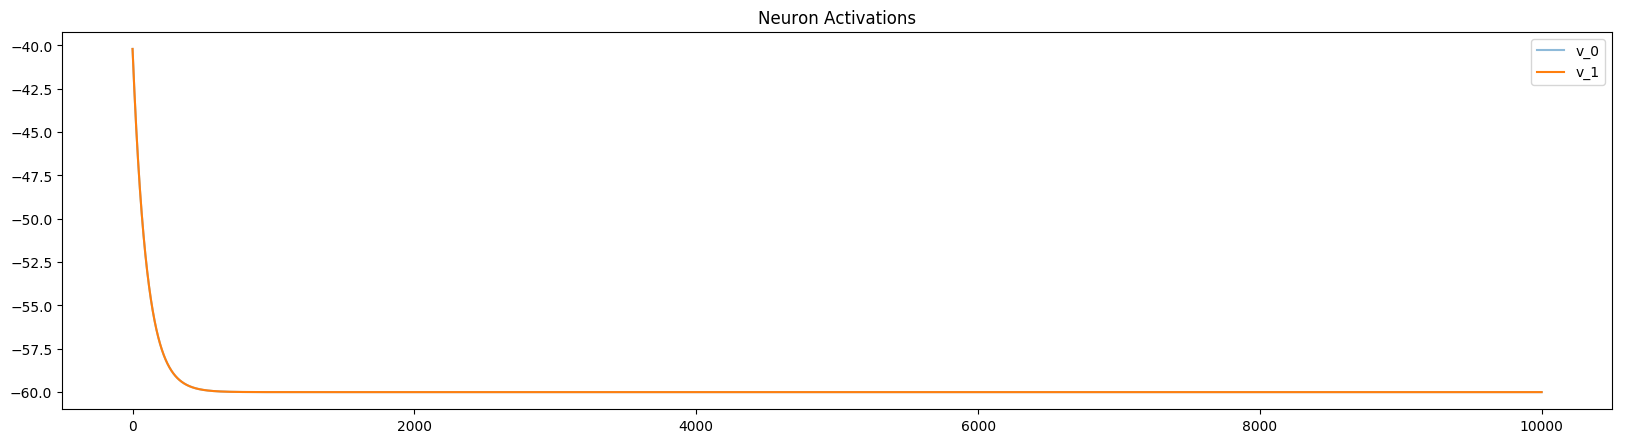

In [9]:
plt.figure(figsize=(20,5))
plt.title('Neuron Activations')
n = 2
for i in range(n):
    plt.plot([y[i] for y in output[0][0]], label='v_'+str(i), alpha=(i+1.0)/(n))
plt.legend()
plt.show()